Using UNSW_NB15_traintest_backdoor.csv available in Electronic Reserves, build a Fully Connected Neural Network in keras to classify rows as 1 anomaly or 0 normal.  This dataset is not large and will not take long to train; therefore, your computers should be fine, and you should not be waiting long for results.

Follow the standard machine learning and data analysis steps we have used to date in the class to deliver a comprehensive notebook from EDA to final analysis.
Use any tools we have covered in the class as you feel best suits.

Tune your network and try to maximize classification performance.  The architecture of the DNN is for you to design (layers, nodes, dropouts, activation functions, epochs, etc.).  Describe how you went about this and what seemed to work best in a MARKDOWN cell – not as a comment in the code.


# Approach
* Import the libraries
* Load the data file
* Understanding of the data, missing values, null values
    * Check the distribution of classes
    * Correlation heat map
    * Separation of features and target
* Use GridSearchCV to find the best hyperparameter
* Create the Models and visualize them using confusion matrix and Tensorboard

# 1. Development of the first Model

* Train Test Split, test size 20%
    * Feature scaling using a standard scaler
    * Fit_transform of the training data
    * Transform of the test data
    * Class weight adjustment for the loss function to give more importance to the minority class

* Define training hyperparameters according to GridSearchCV output
    * Batch size 
    * Epochs 
    * Adam optimizer

* Created Sequential model
    * Output Layer, sigmoid, binary classification
    * Hidden Layer, 32 neurons RelU activation
    * Dropout Layer to reduce overfitting by 50%
    * Input Layer with 64 neurons and ReLU activation

* EarlyStopping 5 to stop the training if the AUC does not improve for 5 sonsecute epochs
* Logging for visualization in TensorBoard
* Compile the model using binary_crossentropy loss function and Accuracy metrics
* Split traingin data further 80/20
* Print confusion Matrix and Classification report
* Plot Training vs Validation loss
* Plot Training vs Validation Accuracy
* Visualize tensorboard

# 2. Developed a second model using SMOTE
Followed the same steps as for model 1


# Import the Libraries

In [1]:
!pip install imblearn

In [1]:
# We Load the libraries - Load them all here - not sprinkled throughout the notebook.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop

import imblearn 
from imblearn.over_sampling import SMOTE #SMOTE - synthetic minority oversampling technique - how the minority datapoints relike to create more balanced data sets
from imblearn.under_sampling import RandomUnderSampler #Random Under Sampler - how the majority datapoints relate to create more balanced data sets
from imblearn.combine import SMOTEENN #SMOTEENN - combines SMOTE and Edited Nearest Neighbors to create a more balanced dataset
from imblearn.over_sampling import RandomOverSampler #Random Over Sampler - how the minority datapoints relate to create more balanced data sets

# from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings('ignore') #ignore warnings

%load_ext tensorboard

# Load the Data

In [2]:
# df_protocol = pd.read_csv('../data/UNSW_NB15_traintest_backdoor.csv') # load the data file
df_protocol = pd.read_csv('../data/creditcard.csv') # load the data file

In [3]:
df_protocol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Exploratory Data Analysis

Class
0    284315
1       492
Name: count, dtype: int64


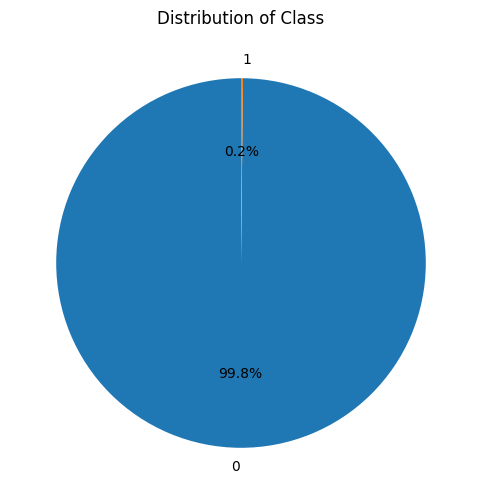

In [5]:
class_counts = df_protocol['Class'].value_counts()
print(class_counts)
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Class')
plt.show()

In [6]:
# summary and details about the data set
df_protocol.info()
df_protocol.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
# check if there are missing values
na_sum = df_protocol.isna().sum()
if na_sum.sum() == 0:
    print("There are no missing values")
else:
    print("There are missing values")

There are no missing values


In [8]:
# df_protocol.dropna(how='any', inplace=True) # to remove rows or columns from the DataFrame that contains missing values

In [9]:
# df_protocol.fillna(df_protocol.mean(), inplace=True)

In [10]:
correlation_matrix = df_protocol.corr()

In [11]:
correlation_matrix

,dur,proto=udp,proto=arp,proto=tcp,proto=igmp,proto=ospf,proto=sctp,proto=gre,proto=ggp,proto=ip,proto=ipnip,proto=st2,proto=argus,proto=chaos,proto=egp,proto=emcon,proto=nvp,proto=pup,proto=xnet,proto=mux,proto=dcn,proto=hmp,proto=prm,proto=trunk-1,proto=trunk-2,proto=xns-idp,proto=leaf-1,proto=leaf-2,proto=irtp,proto=rdp,proto=netblt,proto=mfe-nsp,proto=merit-inp,proto=3pc,proto=idpr,proto=ddp,proto=idpr-cmtp,proto=tp++,proto=ipv6,proto=sdrp,...,state=no,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,class
dur,1.000000,-0.111485,0.128621,0.010222,-0.004936,0.393393,0.010173,-0.002759,-0.001885,-0.001885,-0.001885,0.000012,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,0.000440,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.001885,-0.002468,-0.001885,...,-0.000712,0.147789,0.149731,0.069851,0.156071,-0.055741,0.042247,0.017048,-0.041659,-0.091756,0.080336,0.153702,0.136027,0.236616,0.146703,0.243852,0.010263,-0.018964,-0.015642,-0.023932,0.033586,0.030549,0.031230,-0.018658,0.023775,0.046359,0.113483,0.010999,0.118198,0.030571,-0.008569,0.032070,0.043976,0.002015,0.002025,0.042784,0.007802,0.013170,0.079732,0.039290
proto=udp,-0.111485,1.000000,-0.112483,-0.849902,-0.012313,-0.028910,-0.014765,-0.006882,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.004701,-0.006155,-0.004701,...,-0.001777,-0.255533,-0.173070,-0.155552,-0.109360,0.234434,-0.021473,-0.330225,0.275261,-0.193232,-0.323226,-0.145801,-0.109133,-0.046939,-0.061265,-0.081031,-0.849735,-0.560577,-0.558027,-0.798495,-0.221014,-0.198211,-0.209059,0.027690,-0.283298,-0.179901,-0.043609,0.113197,-0.070826,0.088894,0.119861,0.047327,0.137058,-0.064857,-0.064761,-0.120043,0.077936,0.136039,-0.109898,-0.081337
proto=arp,0.128621,-0.112483,1.000000,-0.317651,-0.004602,-0.010805,-0.005518,-0.002572,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.001757,-0.002301,-0.001757,...,-0.000664,-0.100628,-0.068387,-0.063081,-0.041110,-0.051958,-0.198073,-0.165568,-0.038908,-0.096207,-0.120806,-0.054493,0.944636,0.115136,-0.022304,-0.021677,-0.317589,-0.209516,-0.208563,-0.298438,-0.082604,-0.074081,-0.078136,-0.103325,-0.144513,-0.067238,-0.016299,-0.145083,0.204081,-0.107093,-0.015288,0.056655,-0.084180,-0.024240,-0.024204,-0.044866,-0.122473,-0.137768,0.975358,-0.032447
proto=tcp,0.010222,-0.849902,-0.317651,1.000000,-0.034772,-0.081641,-0.041695,-0.019435,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.013276,-0.017383,-0.013276,...,-0.005018,0.299520,0.206132,0.180699,0.128831,-0.274793,0.038040,0.416463,-0.269439,0.243474,0.380309,0.171550,-0.299302,-0.001986,0.071808,0.091660,0.999803,0.659578,0.656578,0.939514,0.260046,0.233216,0.245980,0.027831,0.359184,0.211673,0.051311,-0.047421,-0.072608,-0.030916,-0.123511,-0.117472,-0.101259,0.076311,0.076198,0.141243,-0.030746,-0.073082,-0.309634,-0.196998
proto=igmp,-0.004936,-0.01231

In [12]:
# plt.figure(figsize=(15,12))
# sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt=".2f")
# plt.yticks(rotation=45) 
# plt.title('Correlation Heatmap')
# plt.show()

In [10]:
# Separate features and target
X = df_protocol.drop(columns=['Class'])
y = df_protocol['Class']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# Create a SMOTE instance
smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy=.5)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [30]:
smoteen = SMOTEENN(random_state=42, sampling_strategy=.5)
X_train_resampled_smoteenn, y_train_resampled_smoteenn = smoteen.fit_resample(X_train, y_train)

Class distribution after SMOTE:
Class
0    227451
1    113725
Name: count, dtype: int64


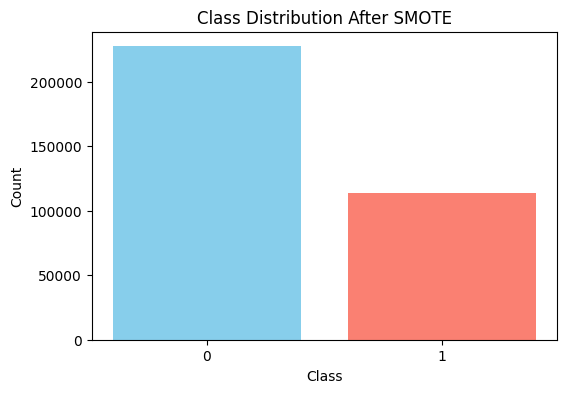

In [13]:
# Show class distribution after SMOTE
resampled_counts = y_train_resampled.value_counts()
print("Class distribution after SMOTE:")
print(resampled_counts)
plt.figure(figsize=(6, 4))
plt.bar(resampled_counts.index.astype(str), resampled_counts.values, color=['skyblue', 'salmon'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution After SMOTE')
plt.show()

Class distribution after SMOTEEN:
class
0    73276
1    36911
Name: count, dtype: int64


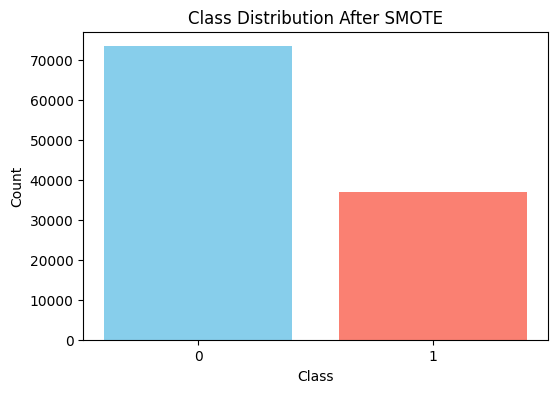

In [32]:
# Show class distribution after SMOTE
resampled_counts = y_train_resampled_smoteenn.value_counts()
print("Class distribution after SMOTEEN:")
print(resampled_counts)
plt.figure(figsize=(6, 4))
plt.bar(resampled_counts.index.astype(str), resampled_counts.values, color=['skyblue', 'salmon'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution After SMOTE')
plt.show()

# Model Development

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)# - `test_size=0.2` reserves 20% of the data for testing.
# # - `random_state=42` ensures reproducibility of the split.
# - `stratify=y` ensures the class distribution is preserved in both training and testing sets.


In [14]:
X_train_resampled_np = X_train_resampled.to_numpy()
X_train_np = X_train.to_numpy()
X_test = X_test.to_numpy() 

In [15]:
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

In [ ]:
# X = X.to_numpy()
# y = y.to_numpy()

In [16]:
X_train.shape

(227845, 30)

In [16]:
X_train_resampled_np.shape

(133920, 196)

In [17]:
# Function to build and compile the model
def create_model(optimizer='nadam', activation='relu', dropout_rate=0.4):
    model = Sequential([
        Dense(32, input_dim=X_train.shape[1], activation=activation),
        Dropout(dropout_rate),
        Dense(16, activation=activation),
        Dense(8, activation='leaky_relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['auc'])
    return model

# Set your chosen hyperparameters manually
chosen_optimizer = Nadam(learning_rate=0.001)  # or RMSprop(learning_rate=0.001)
chosen_activation = 'leaky_relu'
chosen_dropout = 0.1
chosen_epochs = 100
chosen_batch_size = 128

# Create the model
model = create_model(optimizer=chosen_optimizer, activation=chosen_activation, dropout_rate=chosen_dropout)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_np, y_train,
    validation_data=(X_test, y_test),
    epochs=chosen_epochs,
    batch_size=chosen_batch_size,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on test data
test_loss, test_auc = model.evaluate(X_test, y_test)
print(f"Test AUC: {test_auc:.4f}")


Epoch 1/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - auc: 0.4915 - loss: 293.4066 - val_auc: 0.5043 - val_loss: 2.0529
Epoch 2/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.4978 - loss: 2.5555 - val_auc: 0.5036 - val_loss: 0.8197
Epoch 3/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.4959 - loss: 1.0874 - val_auc: 0.5084 - val_loss: 0.7369
Epoch 4/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.5001 - loss: 0.7303 - val_auc: 0.5219 - val_loss: 0.1179
Epoch 5/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.5022 - loss: 0.6577 - val_auc: 0.5054 - val_loss: 0.1002
Epoch 6/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.5129 - loss: 0.2134 - val_auc: 0.5146 - val_loss: 0.0735
Epoch 7/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.5185 - loss: 0.1840 - val_auc: 0.6399 - val_loss: 0.0227
Epoch 8/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.5631 - loss: 0.0564 - val_auc: 0.5017 - val_loss: 0.2183
Epoch 9/100
1781/1781 ━━━━━━━━

In [29]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
input_shape = (30, 1)
model = tf.keras.Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=16, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') # For binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 28, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 12, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 6, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249 (12.69 KB)

 Trainable params: 3,249 (12.69 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = model.fit(
    X_train_np, y_train,
    validation_data=(X_test, y_test),
    epochs=chosen_epochs,
    batch_size=chosen_batch_size,
    callbacks=[early_stopping],
    verbose=1)

Epoch 1/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.5584 - loss: 59.9387 - val_auc: 0.5153 - val_loss: 3.9002
Epoch 2/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.7223 - loss: 1.1989 - val_auc: 0.5663 - val_loss: 0.3980
Epoch 3/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.7730 - loss: 0.3995 - val_auc: 0.8770 - val_loss: 0.2246
Epoch 4/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.8748 - loss: 0.0903 - val_auc: 0.8854 - val_loss: 0.0465
Epoch 5/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.8494 - loss: 0.0422 - val_auc: 0.8978 - val_loss: 0.0123
Epoch 6/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.9022 - loss: 0.0114 - val_auc: 0.9331 - val_loss: 0.0055
Epoch 7/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.8998 - loss: 0.0056 - val_auc: 0.9130 - val_loss: 0.0040
Epoch 8/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.9074 - loss: 0.0045 - val_auc: 0.9415 - val_loss: 0.0083
Epoch 9/100
1781/1781 ━━━━━━━━━

In [28]:
# Predict the values from the testing dataset
y_pred_prob = model.predict(X_test)
# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step
Confusion Matrix:
[[56857     7]
 [   19    79]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.81      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,998 (19.53 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,333 (13.02 KB)

In [19]:
# Predict the values from the testing dataset
y_pred_prob = model.predict(X_test)
# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step
Confusion Matrix:
[[56851    13]
 [   63    35]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.36      0.48        98

    accuracy                           1.00     56962
   macro avg       0.86      0.68      0.74     56962
weighted avg       1.00      1.00      1.00     56962



In [34]:
# Predict the values from the testing dataset
y_pred_prob = model.predict(X_test)
# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

596/596 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step
Confusion Matrix:
[[18590    10]
 [   40   426]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18600
           1       0.98      0.91      0.94       466

    accuracy                           1.00     19066
   macro avg       0.99      0.96      0.97     19066
weighted avg       1.00      1.00      1.00     19066



In [21]:
print("Resampled Trained Model Results")
# Predict the values from the testing dataset
y_pred_prob = model.predict(X_test)
# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Resampled Trained Model Results
596/596 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step
Confusion Matrix:
[[18420   180]
 [   12   454]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     18600
           1       0.72      0.97      0.83       466

    accuracy                           0.99     19066
   macro avg       0.86      0.98      0.91     19066
weighted avg       0.99      0.99      0.99     19066



In [23]:
print("Resampled Trained Model Results")
# Predict the values from the testing dataset
y_pred_prob = model.predict(X_test)
# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Resampled Trained Model Results
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
Confusion Matrix:
[[18472   128]
 [   18   448]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     18600
           1       0.78      0.96      0.86       466

    accuracy                           0.99     19066
   macro avg       0.89      0.98      0.93     19066
weighted avg       0.99      0.99      0.99     19066



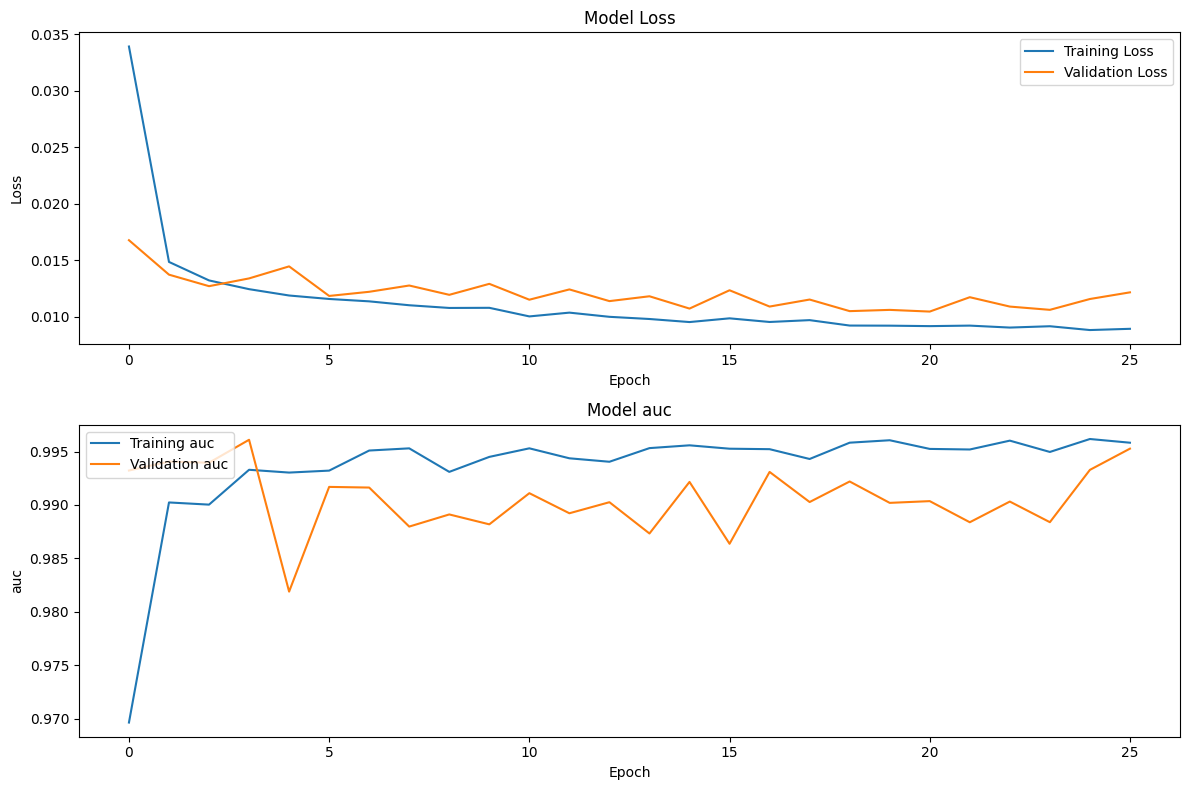

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot training & validation loss values
ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')

# Plot training & validation auc values
ax[1].plot(history.history['auc'], label='Training auc')
ax[1].plot(history.history['val_auc'], label='Validation auc')
ax[1].set_title('Model auc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('auc')
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [18]:
# Feature scaling improves model performance by ensuring all input features are on a similar scale.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)       # Ensure we do not fit with the test data!

In [31]:
import datetime
from tensorflow.keras.callbacks import TensorBoard

# Define the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create the TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [32]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=chosen_epochs,
    batch_size=chosen_batch_size,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Evaluate on test data
test_loss, test_auc = model.evaluate(X_test, y_test)
print(f"Test AUC: {test_auc:.4f}")

Epoch 1/50
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 2s 904us/step - auc: 0.9961 - loss: 0.0090 - val_auc: 0.9946 - val_loss: 0.0104
Epoch 2/50
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 2s 798us/step - auc: 0.9938 - loss: 0.0084 - val_auc: 0.9907 - val_loss: 0.0114
Epoch 3/50
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 2s 800us/step - auc: 0.9969 - loss: 0.0082 - val_auc: 0.9916 - val_loss: 0.0101
Epoch 4/50
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 2s 812us/step - auc: 0.9978 - loss: 0.0081 - val_auc: 0.9918 - val_loss: 0.0113
Epoch 5/50
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 2s 795us/step - auc: 0.9959 - loss: 0.0083 - val_auc: 0.9936 - val_loss: 0.0107
Epoch 6/50
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 2s 809us/step - auc: 0.9957 - loss: 0.0083 - val_auc: 0.9947 - val_loss: 0.0104
Epoch 7/50
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 2s 804us/step - auc: 0.9933 - loss: 0.0087 - val_auc: 0.9938 - val_loss: 0.0101
Epoch 8/50
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 2s 800us/step - auc: 0.9961 - loss: 0.0071 - val_auc: 0.9927 - val_loss: 0.0111
Epoch 9/50
2384/2384 ━━━

596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
Confusion Matrix:
[[18590    10]
 [   38   428]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18600
           1       0.98      0.92      0.95       466

    accuracy                           1.00     19066
   macro avg       0.99      0.96      0.97     19066
weighted avg       1.00      1.00      1.00     19066



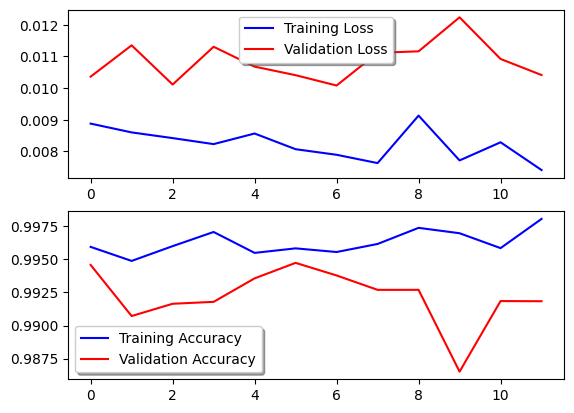

In [33]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['auc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_auc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        12,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,165 (172.52 KB)

 Trainable params: 2,113 (8.25 KB)

 Non-trainable params: 12,608 (49.25 KB)

 Optimizer params: 29,444 (115.02 KB)

In [35]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 27514), started 0:24:18 ago. (Use '!kill 27514' to kill it.)

# Develop a second Model using SMOTE

In [23]:
import tensorflow.keras.backend as K

def reset_weights(model):
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.assign(layer.kernel_initializer(layer.kernel.shape))
        if hasattr(layer, 'bias_initializer'):
            layer.bias.assign(layer.bias_initializer(layer.bias.shape))

reset_weights(model)

In [29]:
# Create an instance of SMOTE
# - `random_state=42` ensures reproducibility of the synthetic samples.
# - `sampling_strategy=0.1` specifies the desired ratio of the minority class (fraud) to the majority class (non-fraud) after resampling.
#   For example, if there are 1,000 majority samples, this strategy will create enough minority samples to make the minority class 10% of the majority class size.
smote = SMOTE(random_state=42, sampling_strategy=0.2)

# Apply SMOTE to the training data
# - `fit_resample()` generates synthetic samples for the minority class based on nearest neighbors of existing samples.
# - It returns the resampled feature set (`X_train_res`) and the corresponding labels (`y_train_res`).
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=chosen_epochs,
    batch_size=chosen_batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 2s 762us/step - auc: 0.9966 - loss: 0.0094 - val_auc: 0.9925 - val_loss: 0.0105
Epoch 2/50
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 2s 674us/step - auc: 0.9963 - loss: 0.0091 - val_auc: 0.9936 - val_loss: 0.0100
Epoch 3/50
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 2s 684us/step - auc: 0.9948 - loss: 0.0086 - val_auc: 0.9915 - val_loss: 0.0108
Epoch 4/50
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 2s 759us/step - auc: 0.9947 - loss: 0.0089 - val_auc: 0.9917 - val_loss: 0.0106
Epoch 5/50
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 2s 685us/step - auc: 0.9930 - loss: 0.0094 - val_auc: 0.9907 - val_loss: 0.0111
Epoch 6/50
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 2s 689us/step - auc: 0.9945 - loss: 0.0087 - val_auc: 0.9897 - val_loss: 0.0119
Epoch 7/50
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 2s 751us/step - auc: 0.9953 - loss: 0.0075 - val_auc: 0.9907 - val_loss: 0.0109


596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
Confusion Matrix:
[[18593     7]
 [   39   427]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18600
           1       0.98      0.92      0.95       466

    accuracy                           1.00     19066
   macro avg       0.99      0.96      0.97     19066
weighted avg       1.00      1.00      1.00     19066



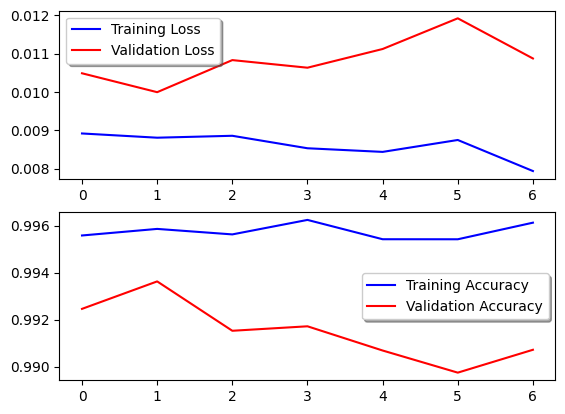

In [30]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['auc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_auc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Freeze the first layer
model.layers[0].trainable = False

In [27]:
for layer in model.layers:
    print(f"Layer: {layer.name}, Trainable: {layer.trainable}")


Layer: dense, Trainable: False
Layer: dropout, Trainable: True
Layer: dense_1, Trainable: True
Layer: dense_2, Trainable: True
